# Data augmentation

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_09 import *

## PIL transforms

In [ ]:
make_rgb._order=0

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [ ]:
def get_il(tfms): return ImageItemList.from_files(path, tfms=tfms)

In [ ]:
il = get_il(tfms)

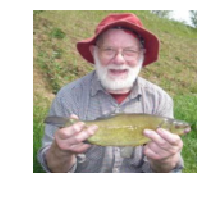

In [ ]:
show_image(il[0])

In [ ]:
img = PIL.Image.open(il.items[0])

Be careful of resampling methods!

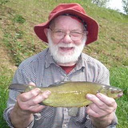

In [ ]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

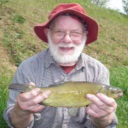

In [ ]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

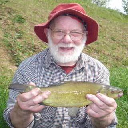

In [ ]:
img.resize((128,128), resample=PIL.Image.NEAREST)

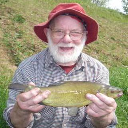

In [ ]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

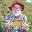

In [ ]:
img.resize((32,32), resample=PIL.Image.NEAREST)

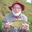

In [ ]:
img.resize((32,32), resample=PIL.Image.ANTIALIAS)

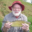

In [ ]:
img.resize((32,32), resample=PIL.Image.BILINEAR)

### Flip

In [ ]:
#export
import random

def show_aug(gen, r=1, c=4, figsize=None):
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for ax in axes.flat:
        ax.imshow(gen())
        ax.axis('off')

In [ ]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

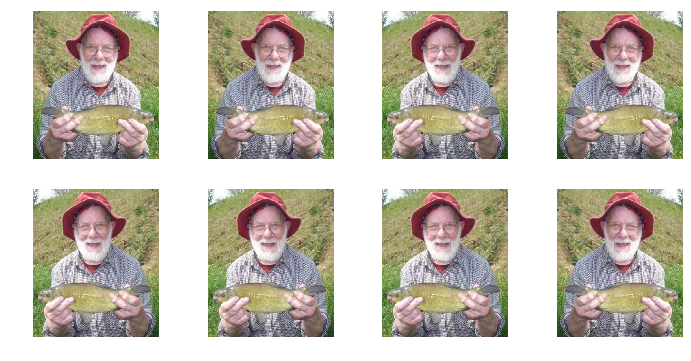

In [ ]:
show_aug(partial(pil_random_flip, img), r=2)

In [ ]:
il1 = get_il(tfms)
il1.items = [il1.items[0]]*8
dl = DataLoader(il1, 8)

In [ ]:
x = next(iter(dl))

In [ ]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, figsize=None):
    n = len(x)
    r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

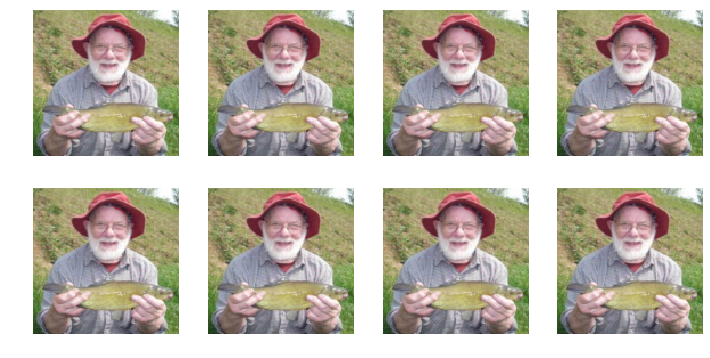

In [ ]:
show_batch(x)

In [ ]:
il1.tfms.append(pil_random_flip)

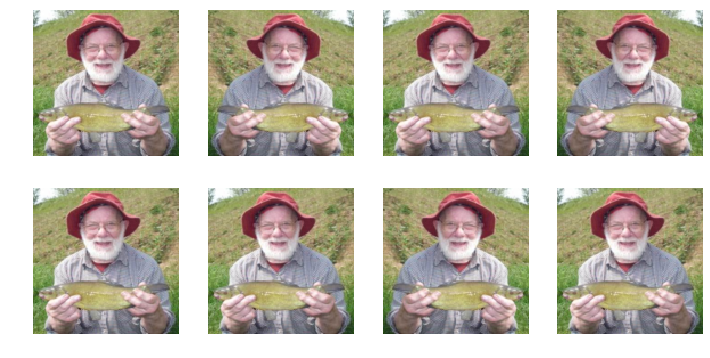

In [ ]:
x = next(iter(dl))
show_batch(x)

In [ ]:
class PilRandomFlip(Transform):
    _order=11
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [ ]:
#export
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [ ]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

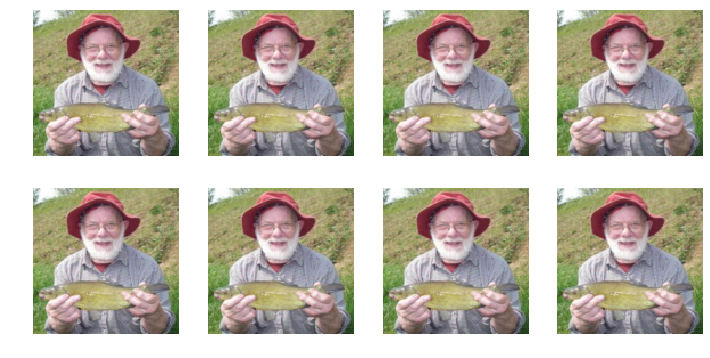

In [ ]:
x = next(iter(dl))
show_batch(x)

In [ ]:
#export
class PilRandomDihedral(PilTransform):
    def __init__(self, p=7/8): self.p=p
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

In [ ]:
PIL.Image.FLIP_LEFT_RIGHT,PIL.Image.ROTATE_270,PIL.Image.TRANSVERSE

(0, 4, 6)

In [ ]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

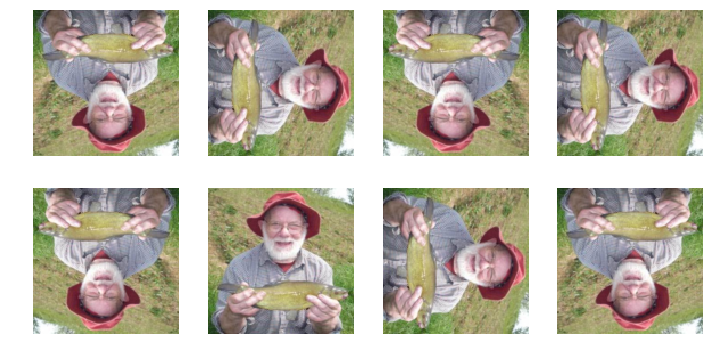

In [ ]:
show_batch(next(iter(dl)))

### Random crop

In [ ]:
img.size

(320, 379)

Regualr cropping

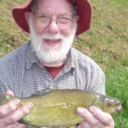

In [ ]:
img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.BILINEAR)

In [ ]:
cnr2 = (60,60,320,320)
resample = PIL.Image.BILINEAR

In [ ]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

165 µs ± 9.19 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our time budget: aim for 5 mins per batch for imagenet on 8 GPUs. 1.25m images in imagenet. So on one GPU per minute that's `1250000/8/5 == 31250`, or 520 per second. Assuming 4 cores per GPU, then we want ~125 images per second - so try to stay <10ms per image.

More evolved cropping

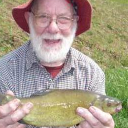

In [ ]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [ ]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

579 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
#export
from random import randint

In [ ]:
def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

In [ ]:
class PilRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        corners = (left, top, left+self.crop_size[0], top+self.crop_size[1])
        return x.transform(self.size, PIL.Image.EXTENT, corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilRandomCrop(128, 256), to_byte_tensor, to_float_tensor]

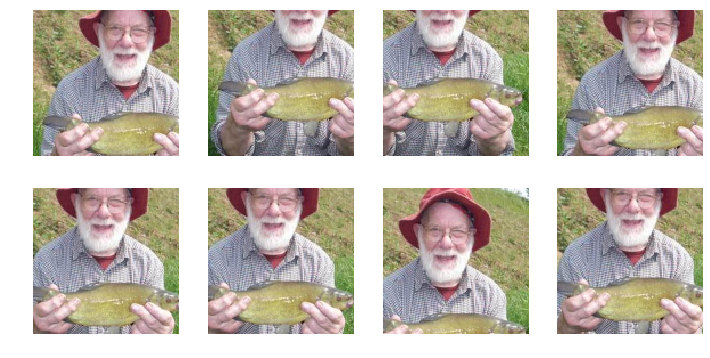

In [ ]:
show_batch(next(iter(dl)))

If we use `PIL.Image.QUAD`, we can specify any coordinates we want this way, which allows us to do perspective warping.

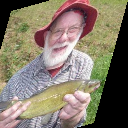

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (-40,-40,60,320,420,420,320,60), resample=resample)

### Perspective warping

To do perspective warping, we map the corners of the image to new points: for instance, if we want to tilt the image so that the top looks closer to us, the top/left corner needs to be shifted to the right and the top/right to the left. To avoid squishing, the bottom/left corner needs to be shifted to the left and the bottom/right corner to the right. For instance if we have an image with corners in:
```
(60,60,60,280,280,280,280,60)
```
(top/left, bottom/left, bottom/right, top/right) then a warped version is
```
(90,60,30,280,310,280,250,60)
```

We need to solve this [equation](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/). The equation solver is [gesv](http://www.netlib.org/lapack/explore-html/d7/d3b/group__double_g_esolve_ga5ee879032a8365897c3ba91e3dc8d512.html) from LAPACK, as implemented in PyTorch.

In [ ]:
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.gesv(B,A)[0][:,0])

In [ ]:
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [ ]:
src = ((-30,-90),(60,280),(250,280),(310,60))

In [ ]:
%timeit -n 10 warp(img, (128,128), src)

806 µs ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 warp(img, (128,128), src, resample=PIL.Image.NEAREST)

311 µs ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


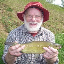

In [ ]:
img.resize((64,64), resample=PIL.Image.NEAREST)

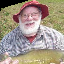

In [ ]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

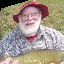

In [ ]:
warp(img, (64,64), src, resample=PIL.Image.NEAREST)

In [ ]:
%timeit -n 10 warp(img, (128,128), src)

806 µs ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 img.resize((128,128), resample=PIL.Image.BILINEAR)

220 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 img.transform((128,128), PIL.Image.PERSPECTIVE, list(find_coeffs(src,targ)), resample=PIL.Image.NEAREST)

303 µs ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


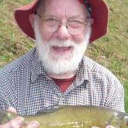

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (60,60,60,280,280,280,280,60), resample=resample)

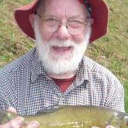

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (60,60,60,280,280,280,280,60), resample=resample)

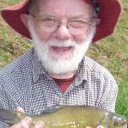

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (90,60,30,280,310,280,250,60), resample=resample)

If, we want to tilt so that the top looks more behind, we just need to shift in the other direction:

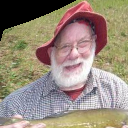

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (-30,-90,60,280,250,280,310,60), resample=resample)

In [ ]:
def uniform(a,b): return a + (b-a) * random()

In [ ]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        tgt_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        tgt_corners = tgt_corners * tensor(self.crop_size).float() + tensor([left,top]).float()
        tgt_corners = tuple([int(o.item()) for o in tgt_corners.view(-1)])
        return x.transform(self.size, PIL.Image.QUAD, tgt_corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 320, magnitude=0.2), to_byte_tensor, to_float_tensor]

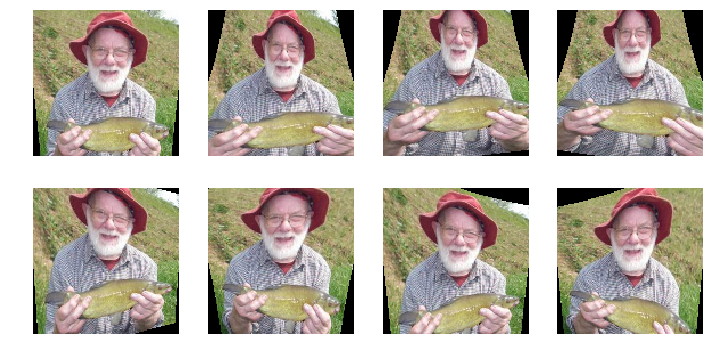

In [ ]:
x = next(iter(dl))
show_batch(x)

Problem is that black padding appears as soon as our target points are outside of the image, so we have to limit the magnitude if we want to avoid that.

In [ ]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        top_magn = min(self.magnitude, left/self.crop_size[0], (x.size[0]-left)/self.crop_size[0]-1)
        lr_magn  = min(self.magnitude, top /self.crop_size[1], (x.size[1]-top) /self.crop_size[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        tgt_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        tgt_corners = tgt_corners * tensor(self.crop_size).float() + tensor([left,top]).float()
        tgt_corners = tuple([int(o.item()) for o in tgt_corners.view(-1)])
        return x.transform(self.size, PIL.Image.QUAD, tgt_corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 256, magnitude=0.2), to_byte_tensor, to_float_tensor]

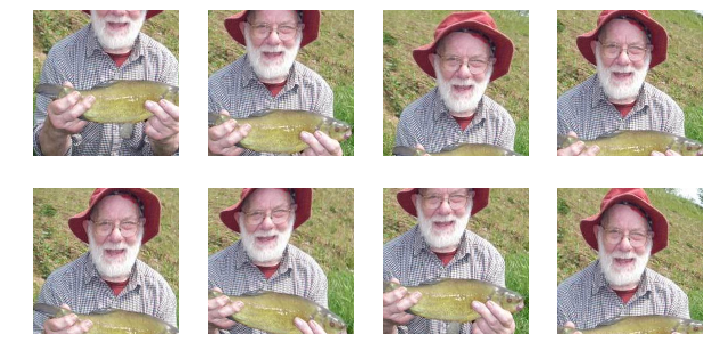

In [ ]:
x = next(iter(dl))
show_batch(x)

## Single tensor transforms

In [ ]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7f798fd5a7b8>),
 (11, <__main__.PilRandomFlip at 0x7f791d23a7b8>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

In [ ]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False))/255.

In [ ]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

1.23 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 np_to_float(img)

358 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
test_near(to_float_tensor(to_byte_tensor(img)), np_to_float(img))

## Export

In [ ]:
!./notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to nb_09.py
